Мне ещё кое-что нужно - аннотация позиций генов.

Задачу нужно делать по выравниванию и для каждой последовательности индивидуально. Мне не важна позиция каждого нуклеотида в последовательности, важна позиция в кодоне. 
В итоге, для каждой веточки пробегается по кодонам, которые были изменены (нужна фиктивная колонка с индексами, чтобы легко выделять позицию в кодоне), собираем информацию о том, что это за мутация (0,1,2 это все, син и фф соотв., так будет легко фильтровать),пишем все в табличку. Отдельно нужно сохранять частоты триплетов и нуклеотидов для каждой родительской ноды.

In [21]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable

In [2]:
path_to_tree = "../data/interim/iqtree_runs/drun1/anc.treefile"
path_to_states = "../data/interim/iqtree_runs/drun1/anc.state"
path_to_leaves = "../data/interim/leaves_states.tsv"

In [3]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [4]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	286
Rooted:	No
Most distant node:	Meloidogyne_javanica
Max. distance:	5.446504


In [5]:
# print(tree.get_ascii())
# tree.show()

In [6]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(2866578, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
6516,Acanthocheilonema_viteae,1,1,A,1.0,0.0,0.0,0.0
6517,Acanthocheilonema_viteae,1,2,T,0.0,0.0,0.0,1.0
6518,Acanthocheilonema_viteae,1,3,T,0.0,0.0,0.0,1.0
6519,Acanthocheilonema_viteae,1,4,T,0.0,0.0,0.0,1.0
6520,Acanthocheilonema_viteae,1,5,T,0.0,0.0,0.0,1.0


In [7]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
...,...,...,...,...,...,...,...,...
10018,Node6,5,2936,T,0.00041,0.00338,0.00014,0.99606
10019,Node6,5,2937,T,0.11066,0.06397,0.06969,0.75568
10020,Node6,5,2938,T,0.09209,0.06654,0.06031,0.78106
10021,Node6,5,2939,T,0.00006,0.00063,0.00002,0.99929


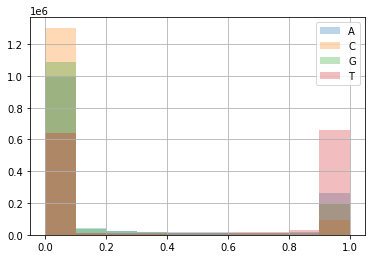

In [10]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [11]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.894154
False    0.105846
dtype: float64

In [13]:
mentr = anc[["p_A", "p_C", "p_G", "p_T"]].apply(entropy, 1)

Text(0.5, 1.0, 'Entropy')

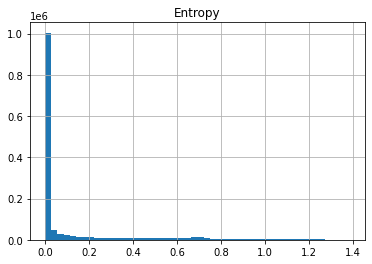

In [14]:
mentr.hist(bins=50)
plt.title("Entropy")

<AxesSubplot:>

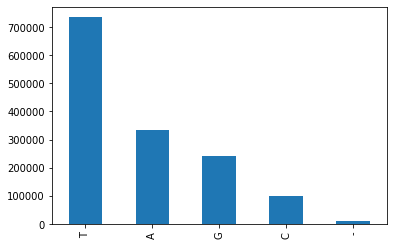

In [15]:
anc.State.value_counts().plot.bar()

## MUTSPEC

In [9]:
mutations = pd.read_csv("../data/processed/nematoda_mutations.csv")
edge_mutspec = pd.read_csv("../data/processed/nematoda_mutspec.csv")

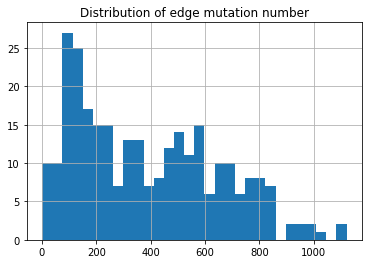

In [16]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

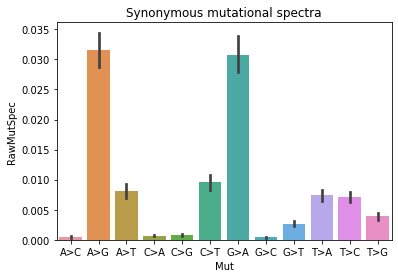

In [19]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec, order=sorted(edge_mutspec.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.savefig("../figures/nematoda_mutspec_syn.svg")
plt.show()

In [24]:
bool(re.match("[ACGT]>[ACGT]", "C>T"))

False

In [25]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")

<AxesSubplot:>

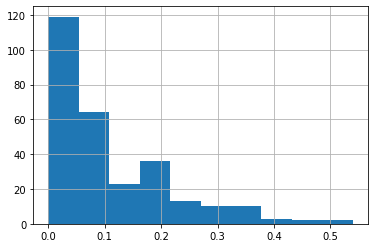

In [28]:
edge_mutspec[edge_mutspec.Mut == pref_sbs]["MutSpec"].hist()

In [32]:
for n1 in "ACGT":
    for n2 in "ACGT":
        if n1 == n2:
            continue

        sbs = f"{n1}>{n2}"
        prepare_one_mut_share_file(edge_mutspec, f"../data/processed/sbs_on_tree/{sbs}_edge_mutspec.tsv", sbs)